# Georgia Tech ISYE6420 Course Project

### Fall 2023  
### Spencer Vore

In [1]:
import pymc as pm
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

import arviz as az
from collections.abc import Sequence
from typing import Optional

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns
import time

## Define adjustable Constants / Settings  
Use this to adjust script settings / MCMC run. I know, I didn't add it to a .env file or something fancier. Works for purpose of demo / tinkering.

In [2]:
n_all = 4000 # Size of data we want for MCMC. Randomly sample this many points from full dataset. Includes train and test sample size.
n_seed = 42 # Random seed for down sampling n datapoints from full dataset

n_test = 2500 # Size of test set we want to saomple from n_all.
split_seed = 43 # Random seed used for train / test split

path_to_datafile = "abalone/abalone.data"

standardize = True # Controls whether to standardize numerical columns

linear_model_n_samples = 5000 # how many samples to draw from MCMC for linear model. Set lower for testing. Set higher for official results.
neural_model_n_samples = 5000 # how many samples to draw from MCMC for neural model.
d_neural_model_n_samples = 5000 # how many samples to draw from MCMC for the deep neural model

Notes:  
1) If the training set is greater than around 1500, PyMC will not start sampling. I beleive it exceeds the capability of my hardware.  
2) Since we have around 4100 samples, and we can't use them all for training, might as well use a large test set.

## Prepare Dataset

**Load Dataset**

In [3]:
data = pd.read_csv(path_to_datafile, header=None)

Below, see that there are both numeric and categorical variables to deal with

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
data.shape

(4177, 9)

**Downsample dataset**  
This will help the MCMC algorithm run faster... can adjust upward for better prediction accuracy, or downward for faster computation. Take random sample of data.

In [6]:
# Uncomment this line to use full datasize
# n = data.shape[0]

In [7]:
n = n_all
assert n <= data.shape[0] # Can't chose more samples than size of data
data = data.sample(n, random_state=n_seed)

**Split data into training and test sets**

In [8]:
data.shape

(4000, 9)

In [9]:
assert n_test < n_all # Test size should be smaller than full size
train_data, test_data = train_test_split(data, test_size=n_test, random_state=split_seed)

In [10]:
train_data.shape

(1500, 9)

In [11]:
test_data.shape

(2500, 9)

**Standardize and one hot encode train dataset**  


In [12]:
class DataPrep:
    """
    Standardize and one hot encode the data. By writing this as an object, we can save the statistics calculated for the standardization
    so we can use them later to predict new datapoints in our model.
    """
    def __init__(self):
        self.means = dict()
        self.stdevs = dict()
        
    def prep(self, X_df: pd.DataFrame, X_df_all: Optional[pd.DataFrame] = None, 
             use_prev_standardization=False, standardize=True) -> pd.DataFrame:
        """
        This takes a dataset, and prepares it. Numerical columns are standardized. Categorical columns 
        are one hot encoded so we can fit a numerical regression with a coefficient for each category.
        
        From TA's example github for numerical standardization
        Standardize input variables by 2 std dev.

        For standardization, see:
        https://stat.columbia.edu/~gelman/research/published/standardizing7.pdf
        https://areding.github.io/6420-pymc/unit7/Unit7-arrhythmia.html
        
        INPUTS:
        X_df - The train or test dataset you want to standardize and one hot encode
        X_df_all - The full dataset you sampled X_df from. Used to check that all categorical values in X_df_all are also in X_df. Otherwise,
            you will get an output dataset that doesn't fully one hot encode the full dataset and your dimensions will be off. If this fails,
            you will need to add more logic to this function to handle the edge case. Right now, it just throws and exception.
        use_prev_standardization - Set this to true is X_df is a test set. This will use previously saved means and stdevs from training set 
            (saved in the object) to standardize the test dataset in the same way. If fasle, will recalculate the means and stdev from X_df.
        
        RETURNS:
        Standardized and one hot encoded dataframe based on X_df input
        """
        
        X_standardized = pd.DataFrame()
            
        for colname in X_df.columns:
            col = X_df[colname]
            if is_numeric_dtype(col):
                if standardize:
                    if not use_prev_standardization:
                        self.means[colname] = col.mean()
                        self.stdevs[colname] = col.std()
                    X_standardized[colname] = (col - self.means[colname]) / (2 * self.stdevs[colname])
                else:
                    if not use_prev_standardization:
                        self.means[colname] = None
                        self.stdevs[colname] = None
                    X_standardized[colname] = col
            else:
                X_onehot = pd.get_dummies(X_df[colname], prefix=colname, dtype=int)
                
                # Make sure all categorical values are in subsample. If this breaks,
                # add logic to handle this edge case, such as inserting missing column where 
                # everything is False
                X_onehot_all = pd.get_dummies(X_df_all[colname], prefix=colname, dtype=int)
                assert set(X_onehot.columns) == set(X_onehot_all.columns)
                    
                if X_standardized.empty:
                    X_standardized = X_onehot
                else:
                    X_standardized = X_standardized.join(X_onehot)
                if not use_prev_standardization:
                    onehot_colnames = X_onehot.columns
                    for o_colname in onehot_colnames:
                        self.means[o_colname] = None
                        self.stdevs[o_colname] = None

        return X_standardized


In [13]:
data_preper = DataPrep()
train_data_std = data_preper.prep(X_df = train_data, X_df_all = data, standardize=standardize)

In [14]:
train_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
1335,1,0,0,0.200543,0.349441,0.317187,0.234926,0.322179,0.113948,0.227865,-0.147831
2944,0,0,1,0.425458,0.498294,0.380956,0.346071,0.278599,0.552176,0.377577,-0.458618
542,0,0,1,-0.433309,-0.419634,-0.320503,-0.559187,-0.596337,-0.575018,-0.458314,0.784530
1128,1,0,0,0.139202,0.150970,0.189649,-0.205130,-0.068917,-0.035140,0.010426,-0.303224
1870,0,1,0,0.016521,0.101352,-0.001658,-0.168417,-0.153841,-0.396564,-0.043042,-0.303224


In [15]:
train_data_std.shape

(1500, 11)

In [16]:
data_preper.means

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.52596,
 2: 0.4095733333333333,
 3: 0.14013,
 4: 0.8444386666666666,
 5: 0.3668376666666666,
 6: 0.18427800000000003,
 7: 0.24207499999999996,
 8: 9.951333333333332}

In [17]:
data_preper.stdevs

{'0_F': None,
 '0_I': None,
 '0_M': None,
 1: 0.12226833099038954,
 2: 0.10077047061211507,
 3: 0.039204052577410005,
 4: 0.49709575103329184,
 5: 0.22373050315036502,
 6: 0.1106730759300738,
 7: 0.14026943674558362,
 8: 3.217638941179192}

In [18]:
X_train = train_data_std.drop(8, axis=1).to_numpy()
y_train = train_data_std[8].to_numpy()

In [19]:
X_train

array([[ 1.        ,  0.        ,  0.        , ...,  0.32217854,
         0.11394822,  0.22786503],
       [ 0.        ,  0.        ,  1.        , ...,  0.27859932,
         0.55217585,  0.37757691],
       [ 0.        ,  0.        ,  1.        , ..., -0.59633725,
        -0.5750179 , -0.45831438],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.50582657,
        -0.38752876, -0.50643605],
       [ 0.        ,  1.        ,  0.        , ..., -0.77735861,
        -0.78283719, -0.8165535 ],
       [ 0.        ,  1.        ,  0.        , ..., -0.62650748,
        -0.64278506, -0.61337311]])

**Apply standardization to test dataset**

Use means and standard deviations from training dataset, so test has exact same standardization.

In [20]:
test_data_std = data_preper.prep(X_df = test_data, X_df_all = data, use_prev_standardization=True, standardize=standardize)

In [21]:
test_data_std.head()

,0_F,0_I,0_M,1,2,3,4,5,6,7,8
2194,0,1,0,-0.392416,-0.419634,-0.384271,-0.479725,-0.517001,-0.410118,-0.435145,0.473743
2879,0,1,0,-0.228841,-0.121927,-0.129196,-0.258943,-0.229825,-0.303949,-0.242658,-0.303224
3320,1,0,0,0.036968,0.076544,0.189649,-0.068336,-0.144901,-0.125496,0.028249,0.939923
691,0,1,0,-1.108055,-1.089473,-0.830654,-0.762367,-0.742719,-0.739918,-0.773779,-0.769405
3415,1,0,0,0.139202,0.275014,0.253418,0.188154,0.145627,0.082324,0.338367,-0.147831


In [22]:
test_data_std.shape

(2500, 11)

In [23]:
X_test = test_data_std.drop(8, axis=1).to_numpy()
y_test = test_data_std[8].to_numpy()

In [24]:
y_test[:40]

array([ 0.47374282, -0.30322441,  0.93992315, -0.76940474, -0.14783096,
        0.00756248, -0.14783096,  1.56149693, -0.14783096, -0.14783096,
       -0.14783096, -0.14783096,  0.31834937,  0.16295593,  0.16295593,
        0.00756248, -0.45861785, -0.45861785,  0.16295593,  0.31834937,
        0.00756248, -0.6140113 ,  0.00756248,  0.00756248, -0.45861785,
       -0.14783096,  0.00756248,  0.16295593, -0.14783096, -0.14783096,
        0.00756248, -0.6140113 , -0.76940474,  0.16295593,  0.93992315,
        0.31834937, -0.45861785, -0.30322441,  0.00756248,  0.16295593])

## Fit linear regression model

Some examples that were referenced:  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-robust.html  
https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html  

Notes about linear regression model:  
1) Through tinkering, it seems to provide better predictions with more informative priors. mu=0 and sigma=5 seem to be best.  
2) Using the robust GLM example, it was found the predictons seemed to work better after replacing pm.Normal with pm.StudentT, and replacing HalfNormal with HalfCauchy.

In [25]:
linear_start = time.time()

In [26]:
with pm.Model() as m_linear:
    # associate data with model (this makes prediction easier)
    X_data = pm.Data("X", X_train, mutable=True)
    y_data = pm.Data("y", y_train, mutable=True)
    
    intercept = pm.StudentT("intercept", mu=0, sigma=5, nu=3)
    coeffs = pm.StudentT("coeffs", mu=0, sigma=5, nu=3, shape=X_data.shape[1])
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = intercept + pm.math.dot(X_data, coeffs)

    # likelihood
    pm.StudentT("age_of_tree", mu=mu, sigma=sigma, nu=3, observed=y_data)

    # start sampling
    trace_linear = pm.sample(linear_model_n_samples)
    ppc = pm.sample_posterior_predictive(trace_linear)
    
    y_pred = ppc.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, coeffs, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 913 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


In [27]:
y_pred.shape

(1500,)

In [28]:
az.summary(trace_linear, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.052,2.430,-4.957,4.660,0.034,0.024,5099.0,6705.0,1.0
coeffs[0],0.012,2.430,-4.717,4.906,0.034,0.024,5100.0,6750.0,1.0
coeffs[1],-0.060,2.430,-4.754,4.873,0.034,0.024,5100.0,6693.0,1.0
coeffs[2],0.047,2.430,-4.663,4.957,0.034,0.024,5096.0,6737.0,1.0
coeffs[3],0.013,0.101,-0.185,0.210,0.001,0.001,11359.0,12576.0,1.0
coeffs[4],0.290,0.104,0.085,0.491,0.001,0.001,11185.0,13487.0,1.0
coeffs[5],0.208,0.042,0.129,0.292,0.000,0.000,20811.0,14079.0,1.0
coeffs[6],1.452,0.203,1.064,1.851,0.002,0.002,8100.0,10657.0,1.0
coeffs[7],-1.292,0.107,-1.501,-1.085,0.001,0.001,9795.0,11952.0,1.0
coeffs[8],-0.372,0.068,-0.508,-0.240,0.001,0.000,12404.0,13252.0,1.0


Above, coefficients 4, 5, 6, 7, 8, and 9 appear statistically significant as their CS doesn't contain zero. One could retry the regression and drop these other variables to see if it improves the linear prediction / fit..

Below, we can visualize the Markov Chain for this mode. Later, we can use this diagram when it gets more complex to try and understand it's flow:

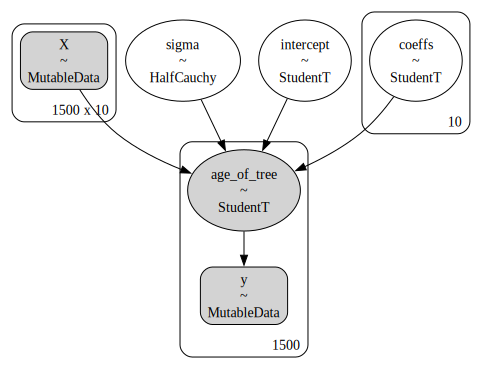

In [29]:
pm.model_to_graphviz(m_linear)

Compute the R2 score of the regression:

In [30]:
az.r2_score(y_train, y_pred)

r2        0.51971
r2_std    0.00000
dtype: float64

Compute the mean squared error of the regression. This is a better metric to compare this to the non-linear models later, as it doesn't have any assumptions of linearity.

In [31]:
round(mean_squared_error(y_train, y_pred), 4)

0.1146

The plot below is a way to evaluate how well predicted values correlate to actual response values. The below graph should ideally have a slope of 1 and pass through 0.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

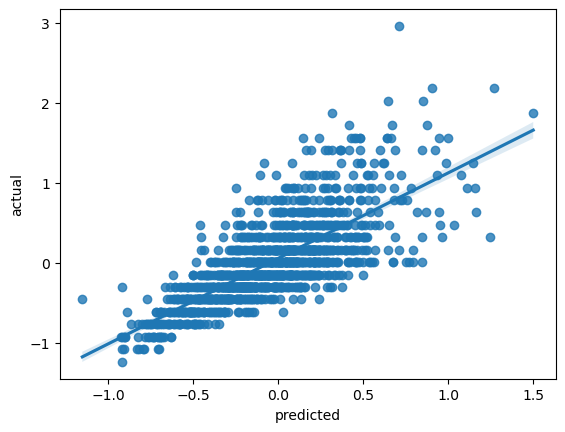

In [32]:
plot = sns.regplot(x=y_pred, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just extract the coefficients, and multiply the test datapoints through them to get a predicted y value. Then, we will compare the predicted y to the known, actual y value.

In [33]:
pred_intercept = trace_linear.posterior.intercept.mean().values.item()
pred_coeffs = trace_linear.posterior.coeffs.mean(["chain", "draw"]).values
y_pred_test_nosample = X_test @  pred_coeffs + pred_intercept

Take Mean Squared error on test set. We get a fairly low number, but slightly larger than training. This prediction method seems to be working well.

In [34]:
round(mean_squared_error(y_test, y_pred_test_nosample), 4)

0.1244

Same plot. We can see the regression line between prediction and actual response values is at a positive 45 degree angle, which means predictions are on average similar to actual response values.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

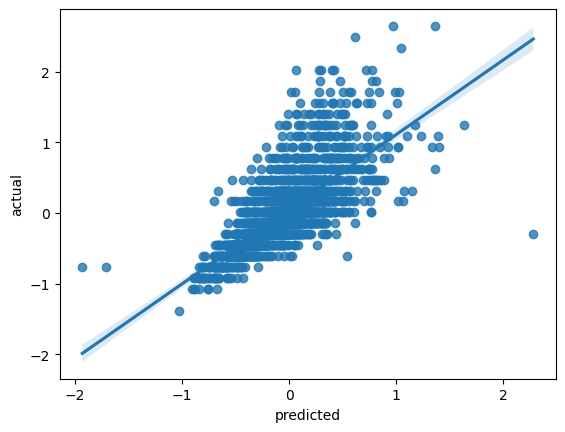

In [35]:
plot = sns.regplot(x=y_pred_test_nosample, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling

In [36]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


Again, get the MSE. We get a much larger value... so sampling appears to be a much less reliable method. Considerable time was spent trying to improve sampling prediction, to no avail.  

In [37]:
round(mean_squared_error(y_test, y_pred_test), 4)

0.2538

This plot does seem very sensitive to the priors in the model. The priors being used here produced the least bad plot below.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

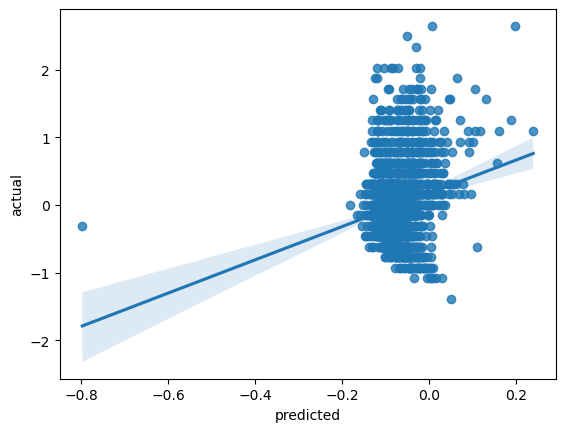

In [38]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

The sampling on the test set seems very unstable. Note how we can get two very different results when we redraw the samples using the same method.

In [39]:
with m_linear:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test = pm.sample_posterior_predictive(trace_linear) #, predictions=True)
    y_pred_test = ppc_test.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs]


Second prediction for MSE after sampling again.

In [40]:
round(mean_squared_error(y_test, y_pred_test), 4)

0.2045

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

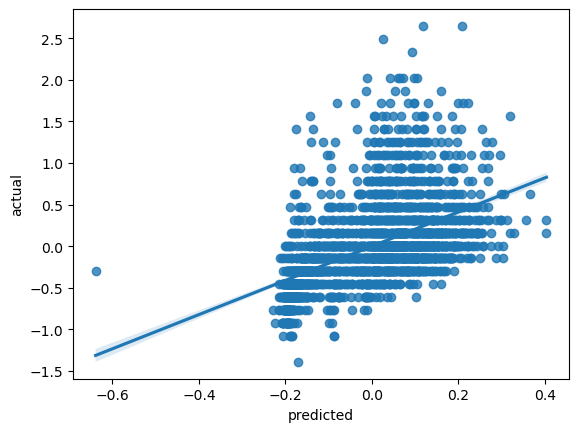

In [41]:
plot = sns.regplot(x=y_pred_test, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [42]:
print(f"Linear model runtime: {round(time.time() - linear_start, 2)} seconds")

Linear model runtime: 938.54 seconds


## Fit Neural Network Model

**Now let's try and build a simple neural network, with 3 neurons. We will keep it small to limit computational complexity.**

In [43]:
neural_start = time.time()

In [44]:
# naming convention. N for neuron. First number is layer. Second is neuron number in that layer. 
# So n21 is the first neuron in layer 2.

with pm.Model() as m_neural:
    # associate data with model (this makes prediction easier)
    X_data_n = pm.Data("X", X_train, mutable=True)
    y_data_n = pm.Data("y", y_train, mutable=True)
    
    # LAYER 1 - Input
    
    # NEURON 1-0
    intercept_n10 = pm.StudentT("intercept_n10", mu=0, sigma=5, nu=3)
    coeffs_n10 = pm.StudentT("coeffs_n10", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n10 = intercept_n10 + pm.math.dot(X_data_n, coeffs_n10)
    
    # ReLU function
    out_n10 = pm.Deterministic("out_n10", pm.math.maximum(0, mu_n10))
        
    sigma_n10 = pm.HalfCauchy("sigma_n10", beta=10)
    

    # NEURON 1-1
    intercept_n11 = pm.StudentT("intercept_n11", mu=0, sigma=5, nu=3)
    coeffs_n11 = pm.StudentT("coeffs_n11", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n11 = intercept_n11 + pm.math.dot(X_data_n, coeffs_n11)
    
    # ReLU function
    out_n11 = pm.Deterministic("out_n11", pm.math.maximum(0, mu_n11))
    sigma_n11 = pm.HalfCauchy("sigma_n11", beta=10)

    
    # NEURON 1-2
    intercept_n12 = pm.StudentT("intercept_n12", mu=0, sigma=5, nu=3)
    coeffs_n12 = pm.StudentT("coeffs_n12", mu=0, sigma=5, nu=3, shape=X_data_n.shape[1])
    
    mu_n12 = intercept_n12 + pm.math.dot(X_data_n, coeffs_n12)
    
    # ReLU function
    out_n12 = pm.Deterministic("out_n12", pm.math.maximum(0, mu_n12))
    
    sigma_n12 = pm.HalfCauchy("sigma_n12", beta=10)


    # LAYER 2 - OUTPUT (no ReLU, just straight linear regression)
    # NEURON 2-0
    intercept_n20 = pm.StudentT("intercept_n20", mu=0, sigma=5, nu=3)
    coeff_n20_0 = pm.StudentT("coeff_n20_0", mu=0, sigma=sigma_n10, nu=3) # input coeff for neron 10 output
    coeff_n20_1 = pm.StudentT("coeff_n20_1", mu=0, sigma=sigma_n11, nu=3) # input coeff for neron 11 output
    coeff_n20_2 = pm.StudentT("coeff_n20_2", mu=0, sigma=sigma_n12, nu=3) # input coeff for neron 12 output

    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_n20 = (intercept_n20 
              + out_n10 * coeff_n20_0 
              + out_n11 * coeff_n20_1
              + out_n12 * coeff_n20_2)

    sigma_n20 = pm.HalfCauchy("sigma_n20", beta=10)

    # likelihood - just take linear combination as regression
    pm.StudentT("age_of_tree", mu=mu_n20, sigma=sigma_n20, nu=3, observed=y_data_n)

    # start sampling
    trace_neural = pm.sample(neural_model_n_samples)
    ppc_neural = pm.sample_posterior_predictive(trace_neural)
    
    y_pred_neural = ppc_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_n10, coeffs_n10, sigma_n10, intercept_n11, coeffs_n11, sigma_n11, intercept_n12, coeffs_n12, sigma_n12, intercept_n20, coeff_n20_0, coeff_n20_1, coeff_n20_2, sigma_n20]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 2191 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


In [45]:
y_pred_neural.shape

(1500,)

In [46]:
# az.summary(trace_neural, hdi_prob=0.95) # prints a LOT of warnings, and hard to see full output due to so many coefficients

This below chart will sort of visualize our neural network structure (as a Markov Chain)


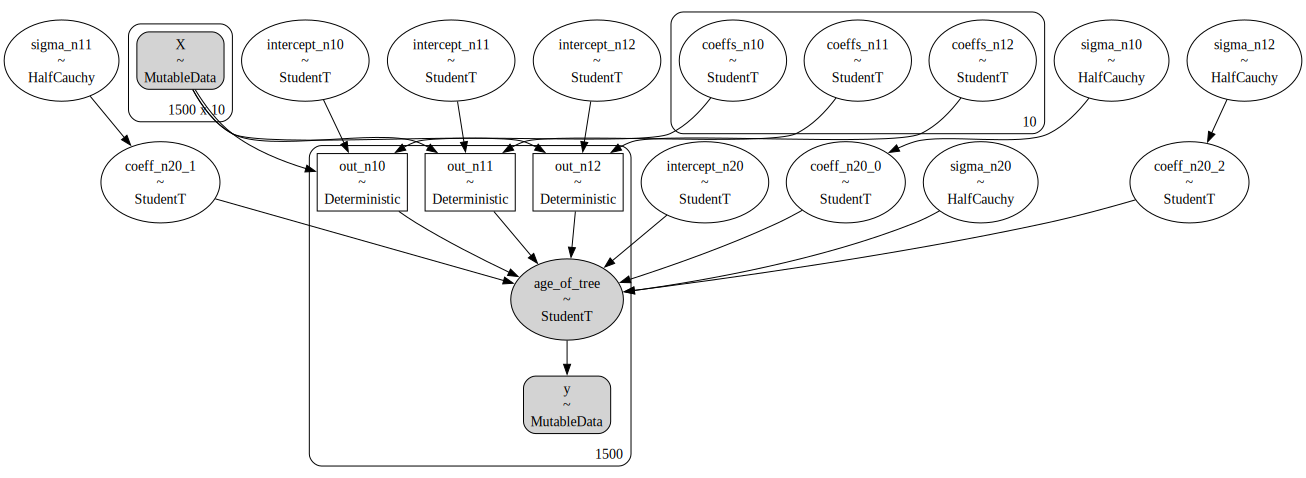

In [47]:
pm.model_to_graphviz(m_neural)

Get R2 score... not sure if this applies to a neural net, but we can see an improvement

In [48]:
az.r2_score(y_train, y_pred_neural)

r2        0.592585
r2_std    0.000000
dtype: float64

Calculate MSE... we get a lower value than the linear model, so that means this network is fitting the training set better... likely due to non-linearities.

In [49]:
round(mean_squared_error(y_train, y_pred_neural), 4)

0.0986

Check correlation between predicted and actual response values, on the training dataset. Again, this chart looks pretty good.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

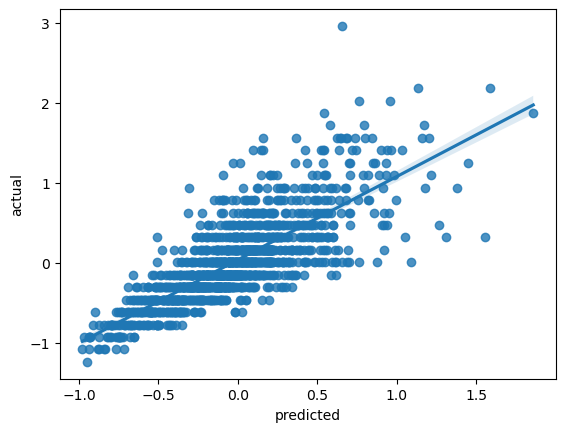

In [50]:
plot = sns.regplot(x=y_pred_neural, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just use coefficients. Kind of a hassle to extract all these individually to recrate the neural network math... I'm trying to be careful.
Hopefully no mistakes. :)

With that said, given the problems with sampling the linear model, we want to try this to see if it provides better results.

In [51]:
# LAYER 1
pred_intercept_n10 = trace_neural.posterior.intercept_n10.mean().values.item()
pred_intercept_n11 = trace_neural.posterior.intercept_n11.mean().values.item()
pred_intercept_n12 = trace_neural.posterior.intercept_n12.mean().values.item()

pred_coeffs_n10 = trace_neural.posterior.coeffs_n10.mean(["chain", "draw"]).values
pred_coeffs_n11 = trace_neural.posterior.coeffs_n11.mean(["chain", "draw"]).values
pred_coeffs_n12 = trace_neural.posterior.coeffs_n12.mean(["chain", "draw"]).values

# Data X coefficients, then ReLU
pred_out_n10 = np.maximum(0, pred_intercept_n10 + X_test @ pred_coeffs_n10)
pred_out_n11 = np.maximum(0, pred_intercept_n11 + X_test @ pred_coeffs_n11)
pred_out_n12 = np.maximum(0, pred_intercept_n12 + X_test @ pred_coeffs_n12)

# LAYER 2
pred_intercept_n20 = trace_neural.posterior.intercept_n20.mean().values.item()
pred_coeff_n20_0 = trace_neural.posterior.coeff_n20_0.mean().values.item()
pred_coeff_n20_1 = trace_neural.posterior.coeff_n20_1.mean().values.item()
pred_coeff_n20_2 = trace_neural.posterior.coeff_n20_2.mean().values.item()

y_pred_test_nosample_neural = (pred_intercept_n20 
          + pred_out_n10 * pred_coeff_n20_0 
          + pred_out_n11 * pred_coeff_n20_1
          + pred_out_n12 * pred_coeff_n20_2)

Get the MSE again.

In [52]:
round(mean_squared_error(y_test, y_pred_test_nosample_neural), 4)

0.3827

See how well predicted vs. actual response values align.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

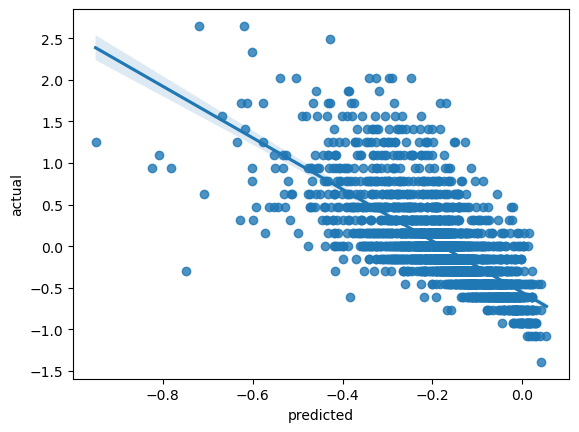

In [53]:
plot = sns.regplot(x=y_pred_test_nosample_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling  
**We are now getting a much lower MSA values, and they seem more stable. The neural net seems to be much better at dealing with possible outliers and non-linearities than the linear model. It's still not perfect.**

In [54]:
with m_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_neural = pm.sample_posterior_predictive(trace_neural) #, predictions=True)
    y_pred_test_neural = ppc_test_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12]


In [55]:
round(mean_squared_error(y_test, y_pred_test_neural), 4)

0.2496

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

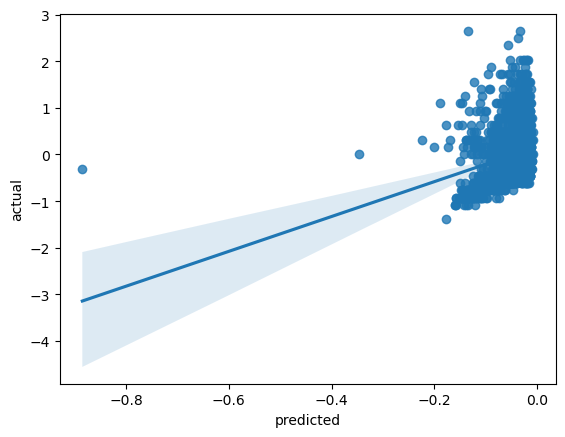

In [56]:
plot = sns.regplot(x=y_pred_test_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Try sampling again, to see how much result differs.

In [57]:
with m_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_neural = pm.sample_posterior_predictive(trace_neural) #, predictions=True)
    y_pred_test_neural = ppc_test_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12]


Second prediction for MSE after sampling again

In [58]:
round(mean_squared_error(y_test, y_pred_test_neural), 4)

0.2466

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

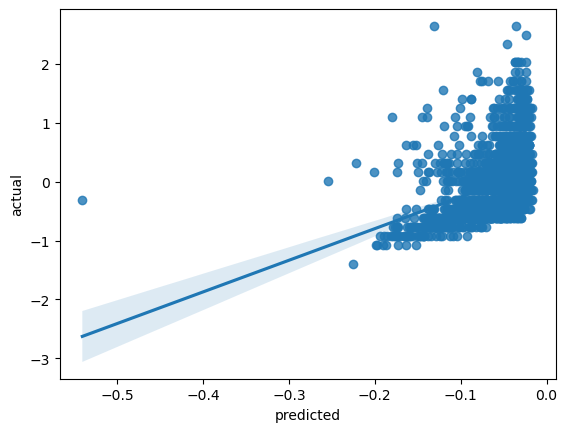

In [59]:
plot = sns.regplot(x=y_pred_test_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [60]:
print(f"Neural model runtime: {round(time.time() - neural_start, 2)} seconds")

Neural model runtime: 2230.04 seconds


## Fit Deep Neural Network Model

**Now let's try to expand our neural network a bit, and add a hidden layer. We will keep it small to limit computational complexity.**

In [61]:
d_neural_start = time.time()

In [62]:
# naming convention. N for neuron. First number is layer. Second is neuron number in that layer. 
# So n21 is the first neuron in layer 2.
with pm.Model() as m_d_neural:
    # associate data with model (this makes prediction easier)
    X_data_dn = pm.Data("X", X_train, mutable=True)
    y_data_dn = pm.Data("y", y_train, mutable=True)
    
    # LAYER 1
    
    # NEURON 1-0
    intercept_dn10 = pm.StudentT("intercept_n10", mu=0, sigma=5, nu=3)
    coeffs_dn10 = pm.StudentT("coeffs_n10", mu=0, sigma=5, nu=3, shape=X_data_dn.shape[1])
    
    mu_dn10 = intercept_dn10 + pm.math.dot(X_data_dn, coeffs_dn10)
    
    # ReLU function
    out_dn10 = pm.Deterministic("out_n10", pm.math.maximum(0, mu_dn10))
        
    sigma_dn10 = pm.HalfCauchy("sigma_n10", beta=10)
    

    # NEURON 1-1
    intercept_dn11 = pm.StudentT("intercept_n11", mu=0, sigma=5, nu=3)
    coeffs_dn11 = pm.StudentT("coeffs_n11", mu=0, sigma=5, nu=3, shape=X_data_dn.shape[1])
    
    mu_dn11 = intercept_dn11 + pm.math.dot(X_data_dn, coeffs_dn11)
    
    # ReLU function
    out_dn11 = pm.Deterministic("out_n11", pm.math.maximum(0, mu_dn11))
    sigma_dn11 = pm.HalfCauchy("sigma_n11", beta=10)

    
    # NEURON 1-2
    intercept_dn12 = pm.StudentT("intercept_n12", mu=0, sigma=5, nu=3)
    coeffs_dn12 = pm.StudentT("coeffs_n12", mu=0, sigma=5, nu=3, shape=X_data_dn.shape[1])
    
    mu_dn12 = intercept_dn12 + pm.math.dot(X_data_dn, coeffs_dn12)
    
    # ReLU function
    out_dn12 = pm.Deterministic("out_n12", pm.math.maximum(0, mu_dn12))
    
    sigma_dn12 = pm.HalfCauchy("sigma_n12", beta=10)

    
    # NEURON 1-3
    intercept_dn13 = pm.StudentT("intercept_n13", mu=0, sigma=5, nu=3)
    coeffs_dn13 = pm.StudentT("coeffs_n13", mu=0, sigma=5, nu=3, shape=X_data_dn.shape[1])
    
    mu_dn13 = intercept_dn13 + pm.math.dot(X_data_dn, coeffs_dn13)
    
    # ReLU function
    out_dn13 = pm.Deterministic("out_n13", pm.math.maximum(0, mu_dn13))
    
    sigma_dn13 = pm.HalfCauchy("sigma_n13", beta=10)

    
    # LAYER 2 - HIDDEN LAYER
    # NEURON 2-0
    intercept_dn20 = pm.StudentT("intercept_n20", mu=0, sigma=5, nu=3)
    coeff_dn20_0 = pm.StudentT("coeff_n20_0", mu=0, sigma=sigma_dn10, nu=3) # input coeff for neron 10
    coeff_dn20_1 = pm.StudentT("coeff_n20_1", mu=0, sigma=sigma_dn11, nu=3) # input coeff for neron 11
    coeff_dn20_2 = pm.StudentT("coeff_n20_2", mu=0, sigma=sigma_dn12, nu=3) # input coeff for neron 12
    coeff_dn20_3 = pm.StudentT("coeff_n20_3", mu=0, sigma=sigma_dn13, nu=3) # input coeff for neron 13

    
    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_dn20 = (intercept_dn20 
              + out_dn10 * coeff_dn20_0 
              + out_dn11 * coeff_dn20_1
              + out_dn12 * coeff_dn20_2
              + out_dn13 * coeff_dn20_3
              )
    
    # ReLU function
    out_dn20 = pm.Deterministic("out_dn20", pm.math.maximum(0, mu_dn20))

    sigma_dn20 = pm.HalfCauchy("sigma_n20", beta=10)
    
    
    # NEURON 2-1
    intercept_dn21 = pm.StudentT("intercept_n21", mu=0, sigma=5, nu=3)
    coeff_dn21_0 = pm.StudentT("coeff_n21_0", mu=0, sigma=sigma_dn10, nu=3) # input coeff for neron 10
    coeff_dn21_1 = pm.StudentT("coeff_n21_1", mu=0, sigma=sigma_dn11, nu=3) # input coeff for neron 11
    coeff_dn21_2 = pm.StudentT("coeff_n21_2", mu=0, sigma=sigma_dn12, nu=3) # input coeff for neron 12
    coeff_dn21_3 = pm.StudentT("coeff_n21_3", mu=0, sigma=sigma_dn13, nu=3) # input coeff for neron 13

    
    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_dn21 = (intercept_dn21 
              + out_dn10 * coeff_dn21_0 
              + out_dn11 * coeff_dn21_1
              + out_dn12 * coeff_dn21_2
              + out_dn13 * coeff_dn21_3
              )

    # ReLU function
    out_dn21 = pm.Deterministic("out_dn21", pm.math.maximum(0, mu_dn21))
    
    sigma_dn21 = pm.HalfCauchy("sigma_n21", beta=10)
    
    
    # NEURON 2-2
    intercept_dn22 = pm.StudentT("intercept_n22", mu=0, sigma=5, nu=3)
    coeff_dn22_0 = pm.StudentT("coeff_n22_0", mu=0, sigma=sigma_dn10, nu=3) # input coeff for neron 10
    coeff_dn22_1 = pm.StudentT("coeff_n22_1", mu=0, sigma=sigma_dn11, nu=3) # input coeff for neron 11
    coeff_dn22_2 = pm.StudentT("coeff_n22_2", mu=0, sigma=sigma_dn12, nu=3) # input coeff for neron 12
    coeff_dn22_3 = pm.StudentT("coeff_n22_3", mu=0, sigma=sigma_dn13, nu=3) # input coeff for neron 13

    
    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_dn22 = (intercept_dn22 
              + out_dn10 * coeff_dn22_0 
              + out_dn11 * coeff_dn22_1
              + out_dn12 * coeff_dn22_2
              + out_dn13 * coeff_dn22_3
              )
    
    # ReLU function
    out_dn22 = pm.Deterministic("out_dn22", pm.math.maximum(0, mu_dn22))
    
    sigma_dn22 = pm.HalfCauchy("sigma_n22", beta=10)
    
    
    # LAYER 3 - OUTPUT (no ReLU, just straight linear regression)
    # NEURON 3-0
    intercept_dn30 = pm.StudentT("intercept_n30", mu=0, sigma=5, nu=3)
    coeff_dn30_0 = pm.StudentT("coeff_n30_0", mu=0, sigma=sigma_dn20, nu=3) # input coeff for neron 20
    coeff_dn30_1 = pm.StudentT("coeff_n30_1", mu=0, sigma=sigma_dn21, nu=3) # input coeff for neron 21
    coeff_dn30_2 = pm.StudentT("coeff_n30_2", mu=0, sigma=sigma_dn22, nu=3) # input coeff for neron 22

    
    # Had a hard time getting this to work as an array / dot product, so just do it manually
    mu_dn30 = (intercept_dn30 
              + out_dn20 * coeff_dn30_0 
              + out_dn21 * coeff_dn30_1
              + out_dn22 * coeff_dn30_2
              )

    sigma_dn30 = pm.HalfCauchy("sigma_n30", beta=10)    

    # likelihood - just take linear combination as regression
    pm.StudentT("age_of_tree", mu=mu_dn30, sigma=sigma_dn30, nu=3, observed=y_data_dn)

    # start sampling
    trace_d_neural = pm.sample(d_neural_model_n_samples)
    ppc_d_neural = pm.sample_posterior_predictive(trace_d_neural)
    
    y_pred_d_neural = ppc_d_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_n10, coeffs_n10, sigma_n10, intercept_n11, coeffs_n11, sigma_n11, intercept_n12, coeffs_n12, sigma_n12, intercept_n13, coeffs_n13, sigma_n13, intercept_n20, coeff_n20_0, coeff_n20_1, coeff_n20_2, coeff_n20_3, sigma_n20, intercept_n21, coeff_n21_0, coeff_n21_1, coeff_n21_2, coeff_n21_3, sigma_n21, intercept_n22, coeff_n22_0, coeff_n22_1, coeff_n22_2, coeff_n22_3, sigma_n22, intercept_n30, coeff_n30_0, coeff_n30_1, coeff_n30_2, sigma_n30]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 5095 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Sampling: [age_of_tree]


In [63]:
y_pred_d_neural.shape

(1500,)

In [64]:
# az.summary(trace_d_neural, hdi_prob=0.95) # Lots of warnings, and too many coefficients to display

Again, we will visualize the Markov Chain. Notice how this is looks like a neural net.

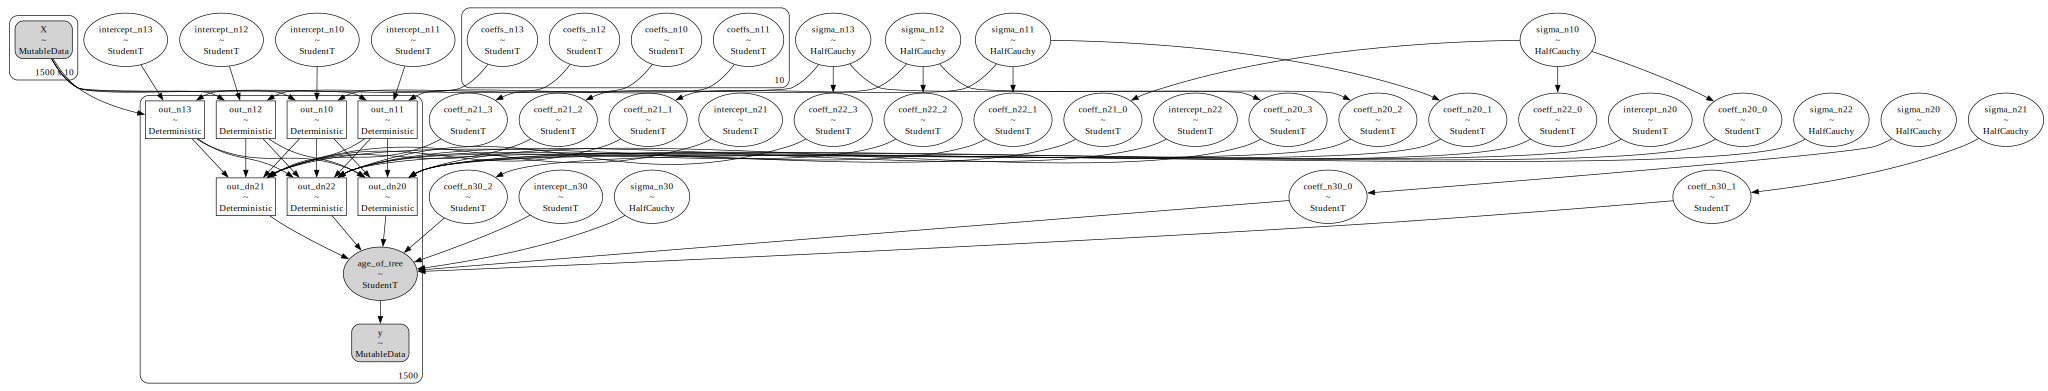

In [65]:
pm.model_to_graphviz(m_d_neural)

Again, we get a higher R2 value.

In [66]:
az.r2_score(y_train, y_pred_d_neural)

r2        0.640298
r2_std    0.000000
dtype: float64

We also get the lowest training MSE value.

In [67]:
round(mean_squared_error(y_train, y_pred_d_neural), 4)

0.0846

The below plot still shows predicted values align well with actual values.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

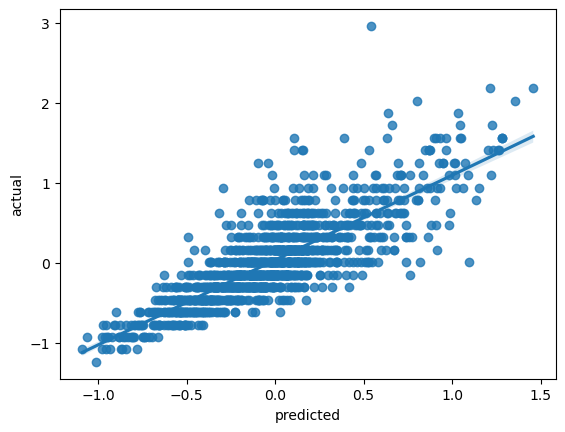

In [68]:
plot = sns.regplot(x=y_pred_d_neural, y=y_train)
plot.set(xlabel="predicted", ylabel="actual")

**Now lets predict the test set**

First prediction without sampling... just use coefficients. Kind of a hassle to extract all these individually to recrate the neural network math... I'm trying to be careful.
Hopefully no mistakes. :)

Basically, this rewrites the neural network to get each coefficient, and multiply it by the appropriate inputs for each neuron.

In [69]:
# LAYER 1 - Input
pred_intercept_dn10 = trace_d_neural.posterior.intercept_n10.mean().values.item()
pred_intercept_dn11 = trace_d_neural.posterior.intercept_n11.mean().values.item()
pred_intercept_dn12 = trace_d_neural.posterior.intercept_n12.mean().values.item()
pred_intercept_dn13 = trace_d_neural.posterior.intercept_n13.mean().values.item()


pred_coeffs_dn10 = trace_d_neural.posterior.coeffs_n10.mean(["chain", "draw"]).values
pred_coeffs_dn11 = trace_d_neural.posterior.coeffs_n11.mean(["chain", "draw"]).values
pred_coeffs_dn12 = trace_d_neural.posterior.coeffs_n12.mean(["chain", "draw"]).values
pred_coeffs_dn13 = trace_d_neural.posterior.coeffs_n13.mean(["chain", "draw"]).values


# Data X coefficients, then ReLU
pred_out_dn10 = np.maximum(0, pred_intercept_dn10 + X_test @ pred_coeffs_dn10)
pred_out_dn11 = np.maximum(0, pred_intercept_dn11 + X_test @ pred_coeffs_dn11)
pred_out_dn12 = np.maximum(0, pred_intercept_dn12 + X_test @ pred_coeffs_dn12)
pred_out_dn13 = np.maximum(0, pred_intercept_dn13 + X_test @ pred_coeffs_dn13)


# LAYER 2 - Hidden
# Neuron 0
pred_intercept_dn20 = trace_d_neural.posterior.intercept_n20.mean().values.item()
pred_coeff_dn20_0 = trace_d_neural.posterior.coeff_n20_0.mean().values.item()
pred_coeff_dn20_1 = trace_d_neural.posterior.coeff_n20_1.mean().values.item()
pred_coeff_dn20_2 = trace_d_neural.posterior.coeff_n20_2.mean().values.item()
pred_coeff_dn20_3 = trace_d_neural.posterior.coeff_n20_3.mean().values.item()

pred_out_dn20 = np.maximum(0, pred_intercept_dn20 
          + pred_out_dn10 * pred_coeff_dn20_0 
          + pred_out_dn11 * pred_coeff_dn20_1
          + pred_out_dn12 * pred_coeff_dn20_2
          + pred_out_dn13 * pred_coeff_dn20_3
          )

# Neuron 1
pred_intercept_dn21 = trace_d_neural.posterior.intercept_n21.mean().values.item()
pred_coeff_dn21_0 = trace_d_neural.posterior.coeff_n21_0.mean().values.item()
pred_coeff_dn21_1 = trace_d_neural.posterior.coeff_n21_1.mean().values.item()
pred_coeff_dn21_2 = trace_d_neural.posterior.coeff_n21_2.mean().values.item()
pred_coeff_dn21_3 = trace_d_neural.posterior.coeff_n21_3.mean().values.item()

pred_out_dn21 = np.maximum(0, pred_intercept_dn21
          + pred_out_dn10 * pred_coeff_dn21_0 
          + pred_out_dn11 * pred_coeff_dn21_1
          + pred_out_dn12 * pred_coeff_dn21_2
          + pred_out_dn13 * pred_coeff_dn21_3
          )


# Neuron 2
pred_intercept_dn22 = trace_d_neural.posterior.intercept_n22.mean().values.item()
pred_coeff_dn22_0 = trace_d_neural.posterior.coeff_n22_0.mean().values.item()
pred_coeff_dn22_1 = trace_d_neural.posterior.coeff_n22_1.mean().values.item()
pred_coeff_dn22_2 = trace_d_neural.posterior.coeff_n22_2.mean().values.item()
pred_coeff_dn22_3 = trace_d_neural.posterior.coeff_n22_3.mean().values.item()

pred_out_dn22 = np.maximum(0, pred_intercept_dn22
          + pred_out_dn10 * pred_coeff_dn22_0 
          + pred_out_dn11 * pred_coeff_dn22_1
          + pred_out_dn12 * pred_coeff_dn22_2
          + pred_out_dn13 * pred_coeff_dn22_3
          )

# LAYER 3 - OUTPUT
# Single Neuron
pred_intercept_dn30 = trace_d_neural.posterior.intercept_n30.mean().values.item()
pred_coeff_dn30_0 = trace_d_neural.posterior.coeff_n30_0.mean().values.item()
pred_coeff_dn30_1 = trace_d_neural.posterior.coeff_n30_1.mean().values.item()
pred_coeff_dn30_2 = trace_d_neural.posterior.coeff_n30_2.mean().values.item()                           

y_pred_test_nosample_d_neural = (pred_intercept_dn30
          + pred_out_dn20 * pred_coeff_dn30_0 
          + pred_out_dn21 * pred_coeff_dn30_1
          + pred_out_dn22 * pred_coeff_dn30_2
        )

Below, we get a higher MSE value on the test set... so the deep neural network may be starting to overfit. This is why we used a test set for evaluation.

In [70]:
round(mean_squared_error(y_test, y_pred_test_nosample_d_neural), 4)

3.8454

Predicted values still don't seem to align as well to actual values.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

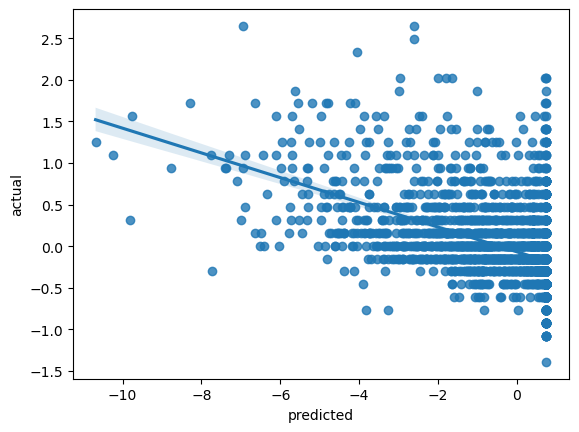

In [71]:
plot = sns.regplot(x=y_pred_test_nosample_d_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

Now predict using sampling  
**We are now getting a much lower MSA values, and they seem more stable. The neural net seems to be much better at dealing with possible outliers and non-linearities than the linear model**

In [72]:
with m_d_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_d_neural = pm.sample_posterior_predictive(trace_d_neural) #, predictions=True)
    y_pred_test_d_neural = ppc_test_d_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12, coeffs_n13]


Again, we get a fairly low MSE value, but it's higher than our non-deep neural network on the test dataset. Another piece of evidence that the model may be overfitting.

In [73]:
round(mean_squared_error(y_test, y_pred_test_d_neural), 4)

0.5959

Plot of predicted vs. response values.

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

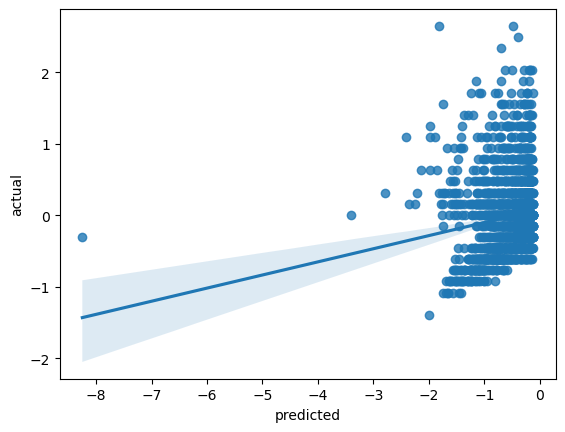

In [74]:
plot = sns.regplot(x=y_pred_test_d_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

The sampling on the test set seems very unstable. Note how we can get two very different results when we redraw the samples.

In [75]:
with m_d_neural:
    pm.set_data({"X": X_test, "y": y_test})
    ppc_test_d_neural = pm.sample_posterior_predictive(trace_d_neural) #, predictions=True)
    y_pred_test_d_neural = ppc_test_d_neural.posterior_predictive.stack(sample=("chain", "draw"))["age_of_tree"].values.T.mean(axis=0)

Sampling: [age_of_tree, coeffs_n10, coeffs_n11, coeffs_n12, coeffs_n13]


Second prediction of MSE for sampling

In [76]:
round(mean_squared_error(y_test, y_pred_test_d_neural), 4)

0.5905

[Text(0.5, 0, 'predicted'), Text(0, 0.5, 'actual')]

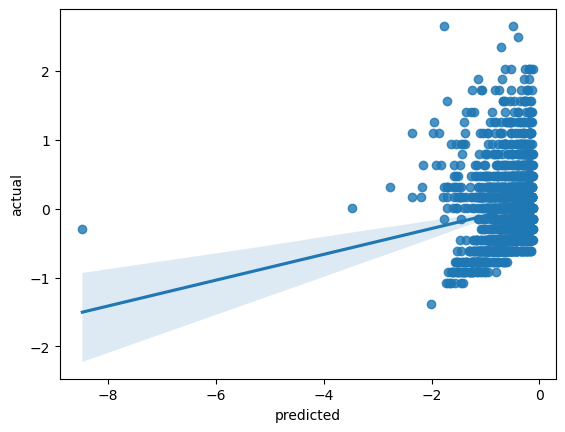

In [77]:
plot = sns.regplot(x=y_pred_test_d_neural, y=y_test)
plot.set(xlabel="predicted", ylabel="actual")

In [78]:
print(f"Deep Neural model runtime: {round(time.time() - d_neural_start, 2)} seconds")

Deep Neural model runtime: 5157.86 seconds


In [79]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sat Dec 02 2023

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.15.0

pytensor: 2.17.3

seaborn: 0.13.0
numpy  : 1.25.2
arviz  : 0.16.1
pymc   : 5.9.1
pandas : 2.1.3



# --------------------------------